In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.metrics import f1_score

from tqdm.auto import tqdm

from IPython.display import clear_output

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import random
from PIL import Image


def set_all_seeds(seed=42):
    # Устанавливаем seed для встроенного генератора Python
    random.seed(seed)
    # Устанавливаем seed для хэш-функции Python (опция для контроля поведения хэшей)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Устанавливаем seed для NumPy
    np.random.seed(seed)

    # Устанавливаем seed для PyTorch
    torch.manual_seed(seed)
    # Устанавливаем seed для генератора на CUDA
    torch.cuda.manual_seed(seed)
    # Отключаем недетерминированное поведение в алгоритмах CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Меня зовут Вершинин Миша

In [2]:
train_dir = r'/kaggle/input/ioai-journey-to-springfield/journey-springfield/train/simpsons_dataset'

In [3]:
classes = os.listdir(train_dir)

In [4]:
df = pd.DataFrame()

In [5]:
paths_lst = []
class_lst = []
for t in classes:
    pth_class = os.path.join(train_dir, t)
    for p in os.listdir(pth_class):
        paths_lst.append(os.path.join(pth_class, p))
        class_lst.append(t)

In [6]:
df['paths'] = paths_lst
df['class_names'] = class_lst

In [7]:
dct_class_in = {classes[t]: t for t in range(len(classes))}
dct_class_out = {y: x for x, y in dct_class_in.items()}

In [8]:
df['class_id'] = df['class_names'].map(dct_class_in)

In [9]:
class SimpsonsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        :param image_paths: список путей к изображениям
        :param labels: список меток классов
        :param transform: аугментации (если None, то применяются стандартные)
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform if transform else self.default_transforms()
    
    def default_transforms(self):
        """Стандартные аугментации для обучения"""
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
train_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=16),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
trainset, valset = train_test_split(df, test_size=0.3, stratify=df['class_id'], random_state=42)

In [12]:
train_dataset = SimpsonsDataset(trainset['paths'].tolist(), trainset['class_id'].tolist(), train_aug)
val_dataset = SimpsonsDataset(valset['paths'].tolist(), valset['class_id'].tolist(), test_aug)

In [13]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epoch):
    model.to(device)
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}
    best_model = None

    for epoch in tqdm(range(num_epoch)):
        model.train()
        total_loss = 0
        for X, y in tqdm(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()

        clear_output(wait=True)
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.show()

    model.load_state_dict(best_model)
    return model, history


In [14]:
def evaluate(model, loader, criterion):
    '''
    args:
        model - our neural network model
        loader — structure which yields batches of test data
        criterion - loss function from `torch.nn` module
        device - the device where the model and data should be placed (e.g., 'cuda' or 'cpu')
    '''

    losses = []
    y_pred_list = []
    y_true_list = []

    model.eval()

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        with torch.no_grad():
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())

        _, y_pred_class = torch.max(y_pred, dim=1)

        y_pred_list.extend(y_pred_class.cpu().numpy())  # move to CPU if using CUDA
        y_true_list.extend(y_batch.cpu().numpy())

    f1 = f1_score(y_true_list, y_pred_list, average='weighted')

    return np.mean(losses), f1

In [15]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
import torch
import torchvision.models as models

num_classes = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = models.efficientnet_b6(weights=models.EfficientNet_B6_Weights.IMAGENET1K_V1)

net.classifier[1] = torch.nn.Linear(net.classifier[1].in_features, num_classes)

net = net.to(device)



Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:03<00:00, 49.7MB/s]


In [17]:
net = torch.nn.DataParallel(net)

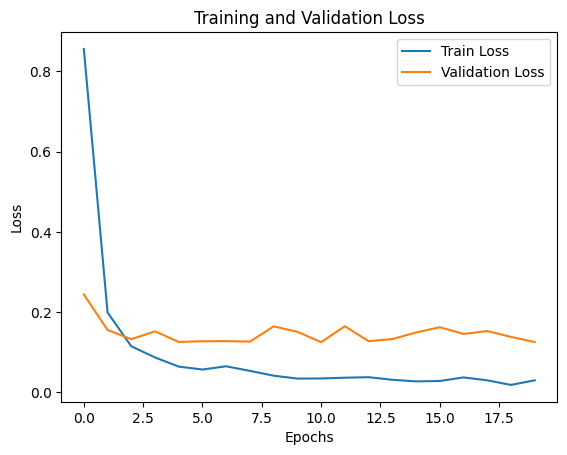

In [18]:
# loss function
criterion = torch.nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [19]:
class SimpsonsTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        """
        :param image_paths: список путей к изображениям
        :param transform: аугментации (если None, то применяются стандартные)
        """
        self.image_paths = image_paths
        self.transform = transform if transform else self.default_transforms()
    
    def default_transforms(self):
        """Трансформации для теста (без аугментации)"""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


In [20]:
test_dir = r'/kaggle/input/ioai-journey-to-springfield/journey-springfield/testset/testset'

test_paths = os.listdir(test_dir)
test_paths = [f'{test_dir}/{x}' for x in test_paths]

In [21]:
test_dataset = SimpsonsTestDataset(test_paths, test_aug)

In [22]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
import torch
import torch.nn.functional as F

def predict(model, dataloader, device="cuda"):
    """
    Делает предсказания на тестовом датасете.

    :param model: обученная модель
    :param dataloader: DataLoader с тестовыми изображениями
    :param class_names: список названий классов (индекс → имя класса)
    :param device: "cuda" или "cpu"
    :return: список кортежей (путь_к_изображению, предсказанный_класс)
    """
    model.eval()  # Переводим в режим оценки
    model.to(device)
    
    predictions = []

    with torch.no_grad():  # Отключаем градиенты для ускорения
        for images in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)  # Получаем предсказания (логиты)
            probs = F.softmax(outputs, dim=1)  # Применяем softmax для вероятностей
            predicted_labels = torch.argmax(probs, dim=1)  # Выбираем классы с максимальной вероятностью
            predictions.extend(predicted_labels)

    return predictions


In [24]:
pred = predict(net, test_loader)

  0%|          | 0/31 [00:00<?, ?it/s]

In [25]:
pred = [int(x) for x in pred]

In [26]:
pred = [dct_class_out[x] for x in pred]

In [27]:
preds = {os.listdir(test_dir)[x]: pred[x] for x in range(len(pred))}

In [28]:
sab = pd.read_csv(r'/kaggle/input/ioai-journey-to-springfield/journey-springfield/sample_submission.csv')

In [29]:
sab

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson
...,...,...
986,img986.jpg,bart_simpson
987,img987.jpg,bart_simpson
988,img988.jpg,bart_simpson
989,img989.jpg,bart_simpson


In [30]:
sab['Expected'] = sab['Id'].map(preds)

In [31]:
sab

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson
...,...,...
986,img986.jpg,sideshow_bob
987,img987.jpg,nelson_muntz
988,img988.jpg,ned_flanders
989,img989.jpg,charles_montgomery_burns


In [32]:
sab.to_csv(r'submission.csv', index=False)

In [33]:
pred

['bart_simpson',
 'homer_simpson',
 'krusty_the_clown',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'nelson_muntz',
 'milhouse_van_houten',
 'bart_simpson',
 'mayor_quimby',
 'marge_simpson',
 'chief_wiggum',
 'chief_wiggum',
 'lisa_simpson',
 'nelson_muntz',
 'edna_krabappel',
 'marge_simpson',
 'edna_krabappel',
 'marge_simpson',
 'charles_montgomery_burns',
 'comic_book_guy',
 'lisa_simpson',
 'nelson_muntz',
 'moe_szyslak',
 'charles_montgomery_burns',
 'bart_simpson',
 'ned_flanders',
 'lenny_leonard',
 'edna_krabappel',
 'kent_brockman',
 'lenny_leonard',
 'charles_montgomery_burns',
 'comic_book_guy',
 'kent_brockman',
 'ned_flanders',
 'krusty_the_clown',
 'krusty_the_clown',
 'milhouse_van_houten',
 'principal_skinner',
 'apu_nahasapeemapetilon',
 'abraham_grampa_simpson',
 'ned_flanders',
 'nelson_muntz',
 'sideshow_bob',
 'apu_nahasapeemapetilon',
 'edna_krabappel',
 'principal_skinner',
 'homer_simpson',
 'edna_krabappel',
 'marge_simpson',
 'sideshow_bob',
 'n